In [1]:
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

/home/yt/miniconda3/envs/mmcv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1000, 500])


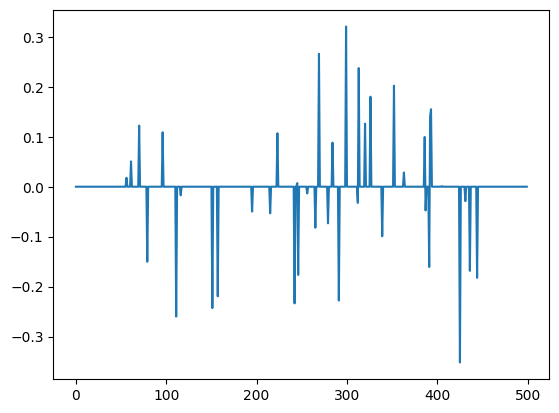

In [2]:
probability = 0.10
# N_data, data_set_size = 450, 1000 # left 25 and right 25 set to zero
N_data, data_set_size = 400, 1000   # left 50 and right 50 set to zero

# Generate Bernoulli mask
bernoulli = (torch.rand(N_data, data_set_size) <= probability).float()

# Generate Gaussian noise and apply mask
signal = bernoulli * torch.randn(N_data, data_set_size)

for col in range(signal.shape[1]):
    signal[:, col] /= (signal[:, col].norm()+1e-8)

signal = signal.permute(1, 0)

# # left 25 and right 25 set to zero
# zeros_25 = torch.zeros((1000,25))
# signal = torch.cat((zeros_25, signal, zeros_25),dim=-1)

# left 50 and right 50 set to zero
zeros_50 = torch.zeros((1000,50))
signal = torch.cat((zeros_50, signal, zeros_50),dim=-1)

print(signal.shape)
plt.plot(signal[5,:].numpy())
plt.show()

Signal shape: torch.Size([1000, 500])


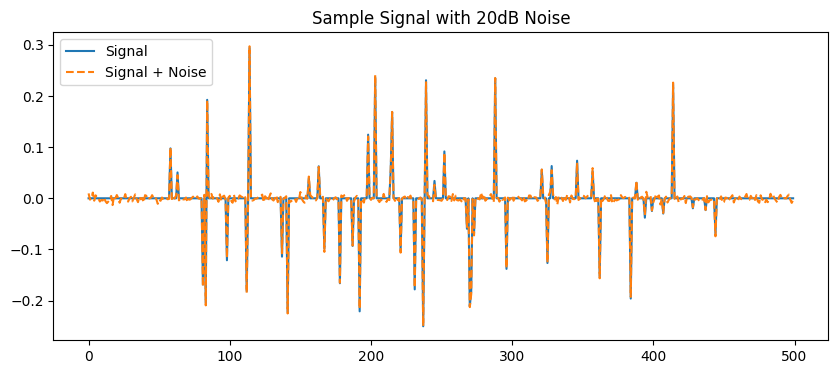

In [3]:
probability = 0.10
N_data, data_set_size = 400, 1000   # inner active region length 400, dataset size 1000
SNR_dB = 20  # desired signal-to-noise ratio in decibels

# Generate Bernoulli mask
bernoulli = (torch.rand(N_data, data_set_size) <= probability).float()

# Generate Gaussian noise and apply mask
signal = bernoulli * torch.randn(N_data, data_set_size)

# Normalize each signal vector (column) individually
for col in range(signal.shape[1]):
    signal[:, col] /= (signal[:, col].norm() + 1e-8)

signal = signal.permute(1, 0)  # shape: (1000, 400)

# Pad left and right with 50 zeros
zeros_50 = torch.zeros((data_set_size, 50))
signal = torch.cat((zeros_50, signal, zeros_50), dim=-1)  # final shape: (1000, 500)

print("Signal shape:", signal.shape)

# =========================
# Generate noise based on desired SNR
# =========================

# Calculate signal power (per vector)
signal_power = (signal**2).mean(dim=1)  # shape: (1000,)

# Compute noise power needed
SNR_linear = 10**(SNR_dB / 10)
noise_power = signal_power / SNR_linear  # shape: (1000,)

# Generate Gaussian noise with mean 0 and variance adjusted per sample
noise = torch.randn_like(signal)

# Normalize noise to unit variance per sample
noise = noise / (noise.std(dim=1, keepdim=True) + 1e-8)

# Scale noise to have the desired power
noise = noise * (noise_power.sqrt().unsqueeze(1))

# Now, noise has the desired SNR relative to signal.

# Add noise to signal
y = signal + noise

# Visualization
plt.figure(figsize=(10,4))
plt.plot(signal[5,:].numpy(), label='Signal')
plt.plot(y[5,:].numpy(), label='Signal + Noise', linestyle='--')
plt.legend()
plt.title(f'Sample Signal with {SNR_dB}dB Noise')
plt.show()


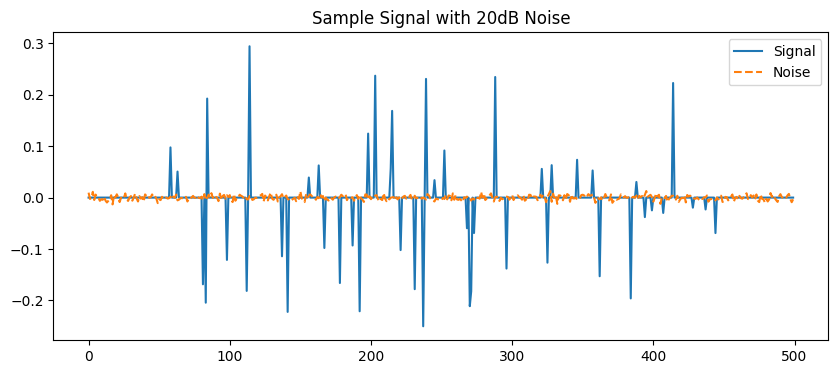

In [4]:
plt.figure(figsize=(10,4))
plt.plot(signal[5,:].numpy(), label='Signal')
plt.plot(noise[5,:].numpy(), label='Noise', linestyle='--')
plt.legend()
plt.title(f'Sample Signal with {SNR_dB}dB Noise')
plt.show()

Measurement Shape: torch.Size([1000, 500])


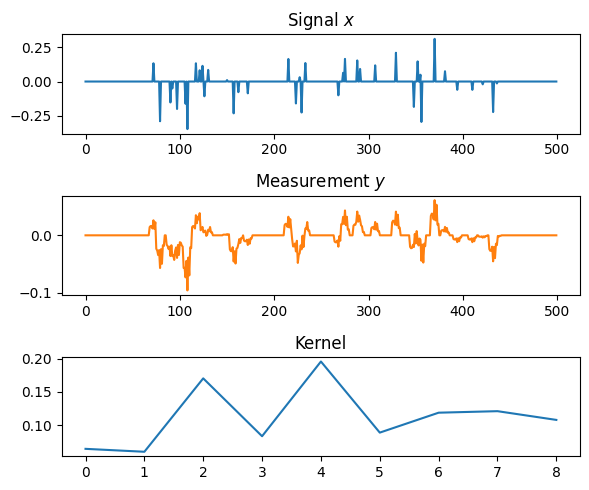

In [207]:
def plot_sig_meas(signal, measurement, kernel, kernel_std=None, fsize=(8, 6), idx=0):
    signal = signal.cpu()
    measurement = measurement.cpu()
    kernel = kernel.cpu()

    plt.figure(figsize=fsize)

    plt.subplot(3, 1, 1)
    plt.plot(signal[idx, :].numpy(), color='tab:blue')
    plt.title('Signal $x$')

    plt.subplot(3, 1, 2)
    plt.plot(measurement[idx, :].numpy(), color='tab:orange')
    plt.title('Measurement $y$')

    plt.subplot(3, 1, 3)
    plt.plot(kernel.numpy())
    if kernel_std is not None:
        plt.title(f'Kernel ($\sigma={kernel_std}$)')
    else:
        plt.title(f'Kernel')
    plt.tight_layout()
    plt.show()

def plot_sig_meas_recon(signal, measurement, reconstruction, idx=0, title1=None, title2=None, title3=None):
    signal = signal.cpu()
    measurement = measurement.cpu()
    reconstruction = reconstruction.cpu()

    plt.figure(figsize=(8, 6))

    plt.subplot(3, 1, 1)
    plt.plot(signal[idx, :].numpy(), color='tab:blue')
    if title1 is not None:
        plt.title(title1)
    else:
        plt.title('Signal $x$')

    plt.subplot(3, 1, 2)
    plt.plot(measurement[idx, :].numpy(), color='tab:orange')
    if title2 is not None:
        plt.title(title2)
    else:
        plt.title('Measurement $y$')

    plt.subplot(3, 1, 3)
    plt.plot(reconstruction[idx, :].numpy())
    if title3 is not None:
        plt.title(title3)
    else:
        plt.title(f'Reconstruction')
    plt.tight_layout()
    plt.show()

def gaussian_kernel(length, std):
    x = torch.linspace(-(length // 2), length // 2, steps=length)
    kernel = torch.exp(-0.5 * (x / std) ** 2)
    kernel /= kernel.sum()
    return kernel

def random_psf(length, normalize=True, seed=42):
    torch.manual_seed(seed)
    psf = torch.rand(length)  # generate random numbers uniformly in [0,1)
    if normalize:
        psf = psf / psf.sum()
    return psf

def forward_operater(signal, kernel):
    # kernel_2d = kernel.view(1, 1, -1, 1) # [1,1,L]
    signal_2d = signal.unsqueeze(1) # [B, C ,L]; C == 1
    return F.conv1d(signal_2d, kernel, padding='same').squeeze()

def adjoint_operater(signal, kernel):
    return forward_operater(signal, kernel)



def soft_threshold(x, threshold=0.001):
    return torch.sign(x) * torch.clamp(torch.abs(x) - threshold, min=0)

device = 'cuda'
# Parameters for Gaussian kernel
kernel_length = 50 # 25, 50
kernel_std = 3.0

# kernel_length = 25 # 25, 50
# kernel_std = 1.0

# kernel = gaussian_kernel(kernel_length, kernel_std)
kernel = random_psf(9,seed=15) + 1e-3

# Convolution Using 2D Convolution (along columns)
kernel_2d = kernel.view(1, 1, -1)

kernel_2d = kernel_2d.to(device)
signal = signal.to(device)
noise = noise.to(device)

measurement = forward_operater(signal, kernel_2d)
# measurement = (forward_operater(signal, kernel_2d) + noise)

print(f"Measurement Shape: {measurement.shape}")

# plot_sig_meas(signal, measurement, kernel, kernel_std, fsize=(6, 5))
plot_sig_meas(signal, measurement, kernel, fsize=(6, 5))


In [208]:
mse_loss = nn.MSELoss(reduction="sum").to(device)

def psnr(x_hat, signal):
  mse = torch.mean((x_hat - signal) ** 2)
  return 20 * torch.log10(1.0 / torch.sqrt(mse))

## GD with Adjoint

In [209]:
iters = 5000
# step_size = 1.8
step_size = 0.005

x_hat = torch.zeros_like(signal).to(device)

recon_loss_adjoint = []
for iter in range(iters):
    residual = forward_operater(x_hat, kernel_2d) - measurement

    grad = adjoint_operater(residual, kernel_2d)

    x_hat -= step_size * grad
    x_hat = soft_threshold(x_hat, step_size*0.005)

    recon_loss_adjoint.append(mse_loss(x_hat, signal).item())
    

PSNR: 29.423486709594727, MSE: 570.9804077148438


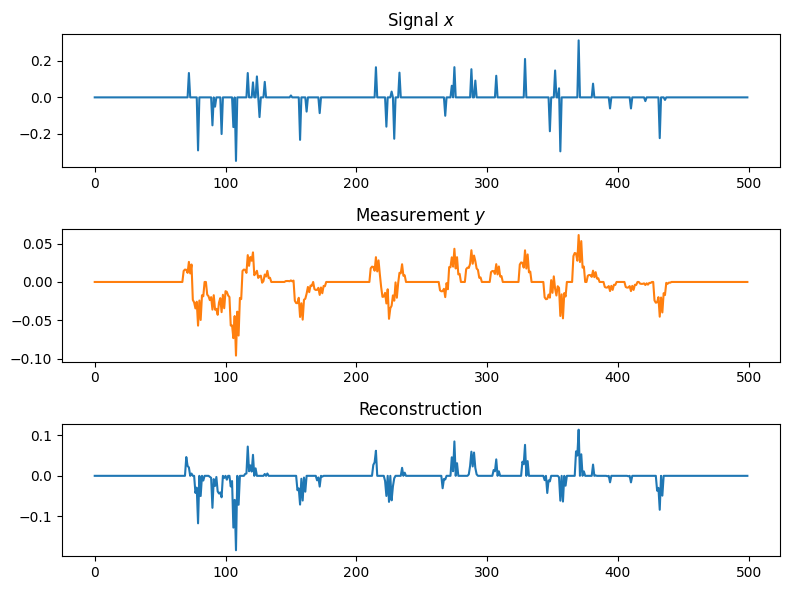

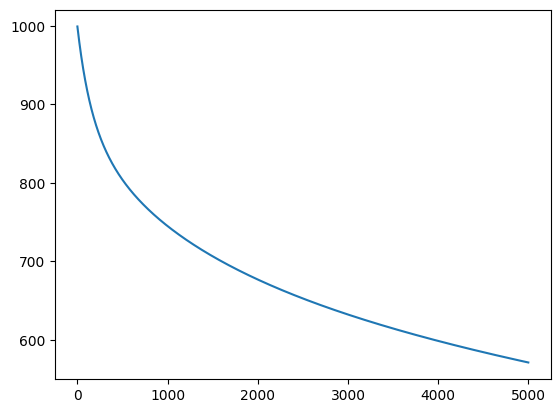

In [210]:
psnr_value = psnr(x_hat, signal)
mse_value = mse_loss(x_hat, signal).item()
print(f"PSNR: {psnr_value}, MSE: {mse_value}")

plot_sig_meas_recon(signal, measurement, x_hat)
plt.plot(recon_loss_adjoint)

In [211]:
torch.argmin(torch.tensor(recon_loss_adjoint))

tensor(4999)

## Wiener Inverse Filtering (1-step)

In [ ]:
def wiener_inverse(measurement, kernel, kernel_length, N_data, data_set_size, SNR=0.0):
    measurement_ori = measurement.clone()
    measurement = measurement.unsqueeze(1) # [B,C,L]
    # Pad the filter to the signal length
    kernel = kernel.unsqueeze(0).unsqueeze(0) # [B,C,L]
    kernel_padded = torch.nn.functional.pad(kernel, (0, measurement.shape[-1] - kernel.shape[-1]))

    # Compute FFT along the last dimension for each instance
    measurement_fft = torch.fft.fft(measurement, dim=-1)
    kernel_fft = torch.fft.fft(kernel_padded, dim=-1)

    if SNR == 0.0:
        snr_hparam = 1e-8
    else:
        snr_hparam = 10 ** (-SNR / 10)
    # # Multiply in the frequency domain: F{x_hat} = F{b} / F{k}
    est_signal_fft = measurement_fft / kernel_fft * (kernel_fft**2 / (kernel_fft**2 + snr_hparam))

    # Inverse FFT to get result back to time domain
    est_signal_ifft = torch.fft.ifft(est_signal_fft, dim=-1).real

    # print(-(kernel.shape[-1] // 2 - 24), -(kernel.shape[-1] // 2))
    # Shift to match 'same' convolution behavior
    # est_signal_ifft = torch.roll(est_signal_ifft, shifts=-(kernel.shape[-1] // 2 - 24), dims=-1)
    est_signal_ifft = torch.roll(est_signal_ifft, shifts=(kernel.shape[-1] // 2), dims=-1)
    est_signal_ifft_recover = est_signal_ifft.squeeze(1) # [L,B]

    return est_signal_ifft_recover, kernel_fft

signal_recon, _ = wiener_inverse(measurement, kernel, kernel_length, N_data, data_set_size, SNR=10)

nan
PSNR: nan


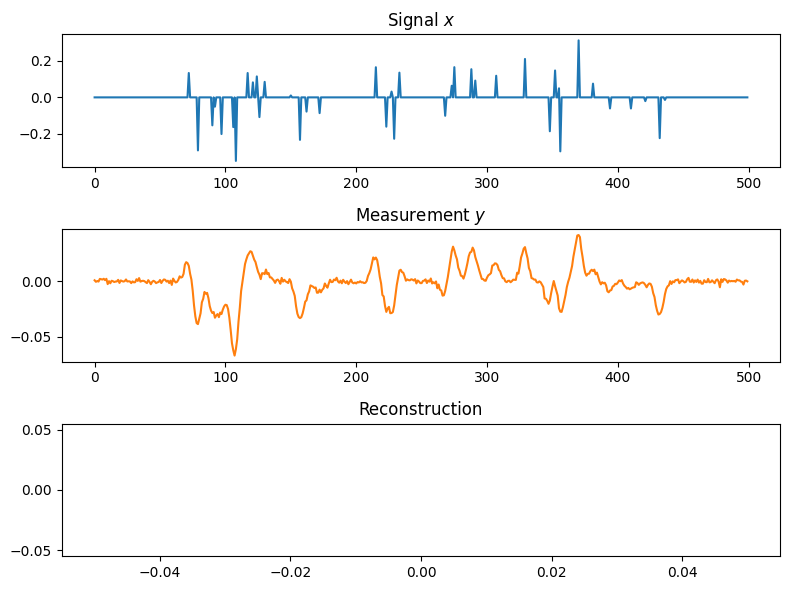

In [ ]:
print(mse_loss(signal_recon, signal).item())
print(f"PSNR: {psnr(signal_recon, signal)}")
plot_sig_meas_recon(signal, measurement, signal_recon)

## Multistep Wiener (pinv)

In [212]:
def pseudo_inverse(residual, kernel, kernel_length, N_data, data_set_size, SNR=0.0):
    if SNR == 0.0:
        gamma = 1e-8
    else:
        gamma = 10 ** (-SNR / 10)
    # gamma = 1e-6
    residual_ori = residual.clone()
    residual = residual.unsqueeze(1) # [B,C,L] -- [1000,1,500]
    # Pad the filter to the signal length
    # kernel = torch.zeros_like(kernel) # sanity check: identity kernel
    # kernel[25//2] = 1.0               # sanity check: identity kernel
    kernel = kernel.unsqueeze(0).unsqueeze(0) # [B,C,L] -- [1,1,25]
    kernel_padded = torch.nn.functional.pad(kernel, (0, residual.shape[-1] - kernel.shape[-1]))

    # Compute FFT along the last dimension for each instance
    residual_fft = torch.fft.fft(residual, dim=-1)
    kernel_fft = torch.fft.fft(kernel_padded, dim=-1)
    kernel_fft = kernel_fft.repeat(1000, 1, 1)

    # Multiply in the frequency domain
    # wiener_filter = kernel_fft.conj() / (torch.abs(kernel_fft)**2) # peudoinverse
    wiener_filter = kernel_fft.conj() / (torch.abs(kernel_fft)**2 + gamma)
    wiener_filter = wiener_filter.to(residual_fft.device)
    # # wiener_filter = kernel_fft # adjoint
    residual_fft = wiener_filter * residual_fft
    # residual_fft = residual_fft / kernel_fft

    # Inverse FFT to get result back to time domain
    residual_ifft = torch.fft.ifft(residual_fft, dim=-1).real

    # Shift to match 'same' convolution behavior
    residual_ifft = torch.roll(residual_ifft, shifts=(kernel.shape[-1] // 2), dims=-1)
    residual_recover = residual_ifft.squeeze(1) # [B,L]

    return residual_recover, wiener_filter

In [ ]:
iters = 5000
# step_size = 1.8     # ISTA 1.0, 1.5
step_size = 0.005  # GD 0.01
signal_recon = torch.zeros_like(signal)

recon_loss_peudo = []
for iter in range(iters):
    residual = forward_operater(signal_recon, kernel_2d) - measurement

    grad, wiener_filter = pseudo_inverse(residual, kernel, kernel_length, N_data, data_set_size, 10)

    signal_recon -= step_size * grad
    signal_recon = soft_threshold(signal_recon, step_size*0.005)

    # recon_loss_peudo.append(torch.norm(torch.abs(signal_recon - signal)).item())
    recon_loss_peudo.append(mse_loss(signal_recon, signal).item())

582.0228881835938
PSNR: 29.340301513671875


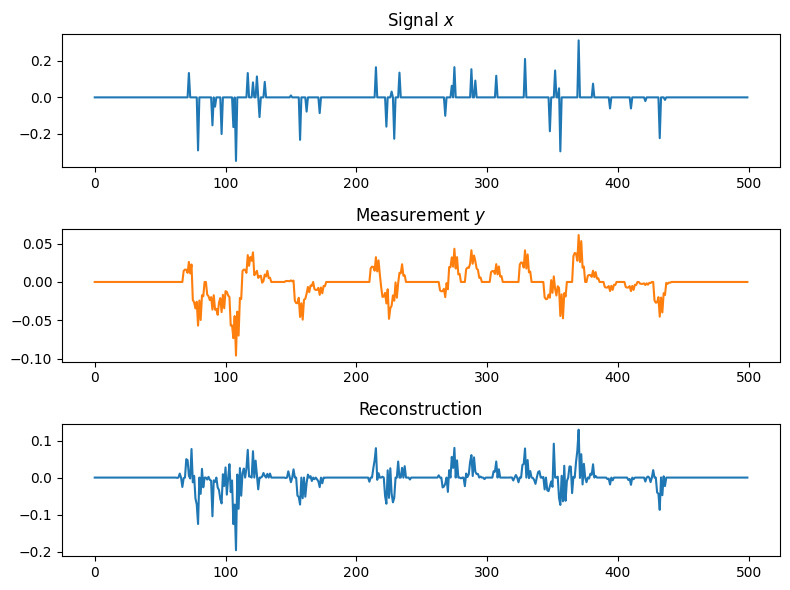

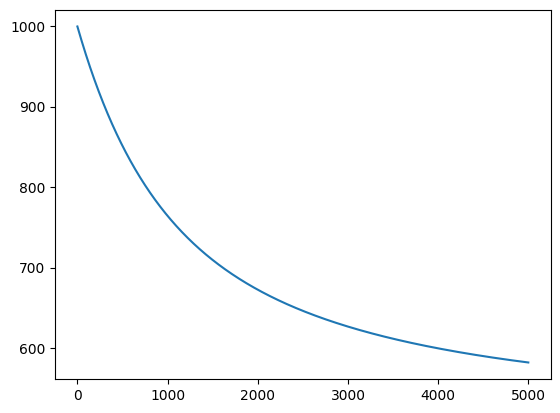

In [249]:
print(mse_loss(signal_recon, signal).item())
print(f"PSNR: {psnr(signal_recon, signal)}")
plot_sig_meas_recon(signal, measurement, signal_recon)
plt.plot(recon_loss_peudo)

In [217]:
torch.argmin(torch.tensor(recon_loss_peudo))

tensor(3863)

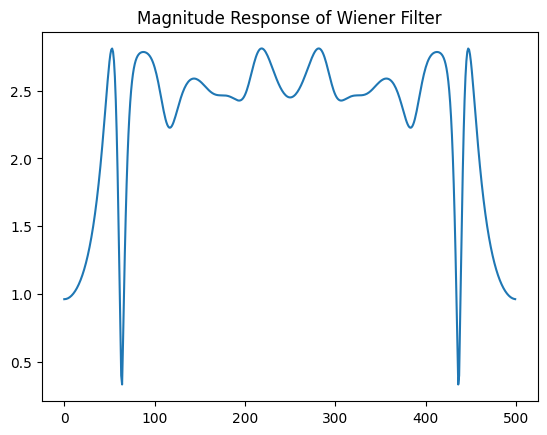

In [218]:
freq_res_winner = torch.abs(wiener_filter[0,0,:]).cpu().numpy()
plt.plot(freq_res_winner)
plt.title("Magnitude Response of Wiener Filter")
plt.show()

## Summary

In [219]:
def sparse_solver(signal, measurement, kernel, iters, step_size, adjoint=True, shrinkage=True, shrinkage_param=0.005, SNR=0.0):
    mse_loss = nn.MSELoss(reduction="sum")
    def psnr(x_hat, signal):
        mse = torch.mean((x_hat - signal) ** 2)
        return 20 * torch.log10(1.0 / torch.sqrt(mse))
    x_hat = torch.zeros_like(signal).to(measurement.device)
    kernel_2d = kernel.view(1, 1, -1).to(measurement.device)
    recon_loss_list = []
    psnr_list = []
    for iter in range(iters):
        residual = forward_operater(x_hat, kernel_2d) - measurement

        if adjoint:
            grad = adjoint_operater(residual, kernel_2d)
        else:
            grad, wiener_filter = pseudo_inverse(residual, kernel, kernel_length, N_data, data_set_size, SNR)

        x_hat -= step_size * grad

        if shrinkage:
            x_hat = soft_threshold(x_hat, step_size*shrinkage_param)

        recon_loss_list.append(mse_loss(x_hat, signal).item())
        psnr_list.append(psnr(x_hat, signal).item())
    return recon_loss_list, psnr_list, x_hat

In [222]:
iters_adjoint = 5000
# step_size_adjoint = 1.8
step_size_adjoint = 0.005
# # Iterative algorithms with adjoint
# ISTA
loss_ista, psnr_ista, recon_ista = sparse_solver(signal, measurement, kernel, iters=iters_adjoint, step_size=step_size_adjoint, adjoint=True, shrinkage=True)
# GD
loss_gd, psnr_gd, recon_gd = sparse_solver(signal, measurement, kernel, iters=iters_adjoint, step_size=step_size_adjoint, adjoint=True, shrinkage=False)

In [221]:
# GD
loss_gd, psnr_gd, recon_gd = sparse_solver(signal, measurement, kernel, iters=iters_adjoint, step_size=0.085, adjoint=True, shrinkage=False)

In [238]:
iters_pinv = 5000
step_size_pinv = 0.001
# # Iterative algorithms with pinv
# loss_ista_pinv, psnr_ista_pinv, recon_ista_pinv = sparse_solver(signal, measurement, kernel, iters=iters_pinv, step_size=0.1, adjoint=False, shrinkage=True, SNR=SNR_dB)
# # GD - pinv
# loss_gd_pinv, psnr_gd_pinv, recon_gd_pinv = sparse_solver(signal, measurement, kernel, iters=iters_pinv, step_size=0.2, adjoint=False, shrinkage=False, SNR=SNR_dB)

# ISTA - pinv ()
loss_ista_pinv, psnr_ista_pinv, recon_ista_pinv = sparse_solver(signal, measurement, kernel, iters=iters_pinv, step_size=0.0003, adjoint=False, shrinkage=True, SNR=15)
# # GD - pinv
# loss_gd_pinv, psnr_gd_pinv, recon_gd_pinv = sparse_solver(signal, measurement, kernel, iters=iters_pinv, step_size=0.08, adjoint=False, shrinkage=False, SNR=3)

In [239]:
# GD - pinv
loss_gd_pinv, psnr_gd_pinv, recon_gd_pinv = sparse_solver(signal, measurement, kernel, iters=iters_pinv, step_size=0.0003, adjoint=False, shrinkage=False, SNR=15)

In [240]:
print(f'MSE ISTA: {loss_ista[-1]:.2f}\t PSNR ISTA: {psnr_ista[-1]:.2f}')
print(f'MSE GD: {loss_gd[-1]:.2f}\t PSNR GD: {psnr_gd[-1]:.2f}')
print(f'MSE ISTA pinv: {loss_ista_pinv[-1]:.2f}\t PSNR ISTA pinv: {psnr_ista_pinv[-1]:.2f}')
print(f'MSE GD pinv: {loss_gd_pinv[-1]:.2f}\t PSNR GD pinv: {psnr_gd_pinv[-1]:.2f}')

MSE ISTA: 570.98	 PSNR ISTA: 29.42
MSE GD: 651.39	 PSNR GD: 28.85
MSE ISTA pinv: 680.18	 PSNR ISTA pinv: 28.66
MSE GD pinv: 708.37	 PSNR GD pinv: 28.49


Text(0.5, 1.0, 'Random kernel length=9, sparsity=10%')

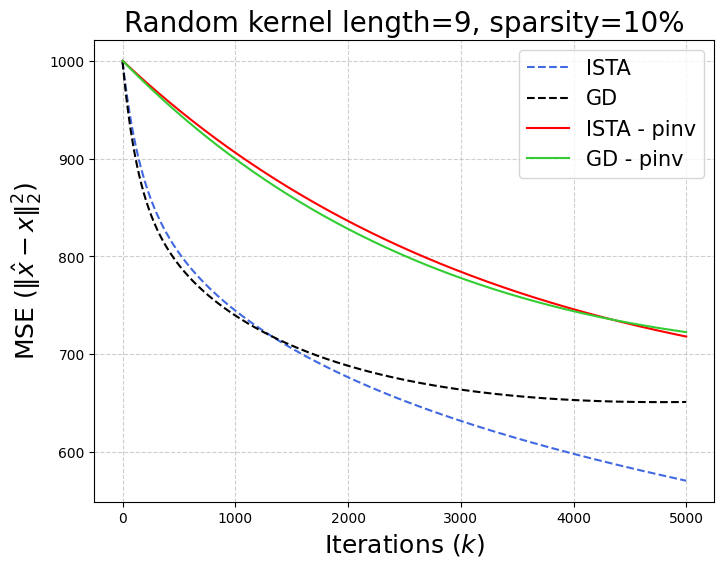

In [235]:
plt.figure(figsize=(8, 6))

iterations = np.arange(0, iters_adjoint)
plt.plot(iterations, loss_ista, linestyle='--', label='ISTA', color='royalblue')
plt.plot(iterations, loss_gd, linestyle='--', label='GD', color='black')

iterations_pinv = np.arange(0, iters_pinv)
plt.plot(iterations_pinv, loss_ista_pinv, linestyle='-', label='ISTA - pinv', color='red')
plt.plot(iterations_pinv, loss_gd_pinv, linestyle='-', label='GD - pinv', color='limegreen')  # Dark Cyan

# Labels and grid
plt.xlabel('Iterations ($k$)', fontsize=18)
plt.ylabel('MSE ($\|\hat{x} - x\|_2^2$)', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.6)

# Legend
plt.legend(fontsize=15, loc='best', ncol=1)

# plt.title(f"kernel length={kernel_length}, $\sigma={kernel_std}$, sparsity={int(probability*100)}%", fontsize=20)
plt.title(f"Random kernel length={9}, sparsity={int(probability*100)}%", fontsize=20)

In [236]:
min(loss_gd_pinv), min(loss_ista_pinv)

(722.7304077148438, 718.21728515625)

Text(0.5, 1.0, 'Random kernel length=9, sparsity=10%')

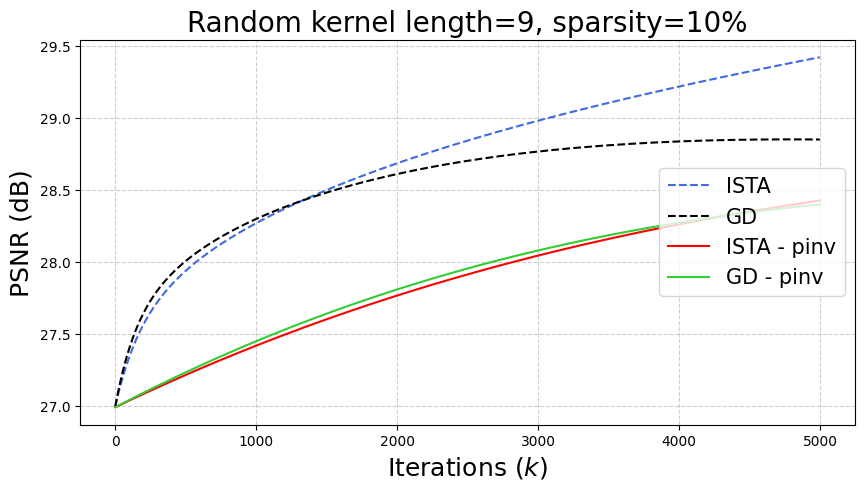

In [237]:
plt.figure(figsize=(10, 5))

iterations = np.arange(0, iters_adjoint)
plt.plot(iterations, psnr_ista, linestyle='--', label='ISTA', color='royalblue')
plt.plot(iterations, psnr_gd, linestyle='--', label='GD', color='black')

plt.plot(iterations_pinv, psnr_ista_pinv, linestyle='-', label='ISTA - pinv', color='red')
plt.plot(iterations_pinv, psnr_gd_pinv, linestyle='-', label='GD - pinv', color='limegreen')  # Dark Cyan

# Labels and grid
plt.xlabel('Iterations ($k$)', fontsize=18)
plt.ylabel('PSNR (dB)', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.6)

# Legend
plt.legend(fontsize=15, loc='center right', ncol=1)

# plt.title(f"kernel length={kernel_length}, $\sigma={kernel_std}$, sparsity={int(probability*100)}%", fontsize=20)
plt.title(f"Random kernel length={9}, sparsity={int(probability*100)}%", fontsize=20)